In [541]:
# pip install giotto-tda
# pip install gudhi

In [542]:
import pandas as pd
import numpy as np
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding
import gudhi 
import math
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import Aer
import qiskit.quantum_info as qi


# import basic plot tools
from qiskit.visualization import plot_histogram

time_series = np.log(pd.read_csv("SP500.csv", header=None).to_numpy().squeeze())

In [543]:
# initial values for important variables -- will have to find optimal values later on

n = 4 # dim of vectors
d = 5 # time delay
w = 5 # window size
epsilon = 0.02 # resolution threshold
q = 3 # number of precision qubits
simplex_dim = 4 # maximum simplex tree dimension used

np.set_printoptions(precision=3, suppress=True)

In [544]:
def TakenEmbedding(time_series, dim, delay):
    serie = time_series.reshape(1, -1)
    TE = TakensEmbedding(time_delay=delay, dimension=dim)
    return TE.fit_transform(serie)[0]

In [545]:
def TakenPointCloud(time_series, dim, delay, window_size):
    embedding = TakenEmbedding(time_series, dim, delay)
    point_cloud = []
    l = len(embedding)
    for i in range(l - window_size):
        window = embedding[i : i + window_size]
        point_cloud.append(window)

    return np.array(point_cloud)

In [546]:
def SimplexTrees(cloud, simplices, resolution):
    rips_complex = gudhi.RipsComplex(points = cloud, max_edge_length = resolution)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension = simplices)

    simplex = [val for val, dist in simplex_tree.get_filtration()]

    simplex = sorted(simplex, key=lambda vector: (len(vector), vector))
    return simplex

In [547]:
import scipy

def unitarize(h):
    if np.any(np.isinf(h)):
        h = np.identity(len(h))
    if not np.allclose(h, h.conj().T, atol = 1e-8):
        print(h)
        raise ValueError("Input matrix H must be Hermitian.")
    ih = 1j * h
    return scipy.linalg.expm(ih)

In [548]:
def BoundaryOperators(simplex_tree, dimension):
    minus = [elem for elem in simplex_tree if len(elem) == dimension] # for 1-simplicities will find all points, etc.
    forms = [elem for elem in simplex_tree if len(elem) == dimension + 1] # for 1-simplicities will find all edges, etc. 

    if(dimension == 0):
        return np.array([[(-1) ** i] for i in range(len([item for item in simplex_tree if len(item) == 1]))])

    operator = []

    for simplex_minus in minus:
        simplices = []

        for simplex_form in forms:
            if(all(item in simplex_form for item in simplex_minus) and len(simplex_minus) + 1 == len(simplex_form)):
                val = list(set(simplex_form) - set(simplex_minus))[0]
                if(val % 2 == 1):
                    simplices.append(-1)
                else:
                    simplices.append(1)
            else:
                simplices.append(0)

        operator.append(simplices)
    return np.array(operator)

In [549]:
def CombinatorialLaplacian(tree, index):    
    delta_k = np.array(BoundaryOperators(tree, index))
    delta_l = np.array(BoundaryOperators(tree, index + 1))

    temp = np.matmul(delta_k.conj().T, delta_k) + np.matmul(delta_l, delta_l.conj().T)

    points = len([items for items in tree if len(items) == index + 1])

    if(len(temp) <= 1):
        return np.array([1])

    dim = 2 ** math.ceil(math.log(points, 2))
    pad = dim - points
    temp = np.pad(temp, (0, pad))

    gershgorin = []
    for i in range(len(temp)):
        sum = 0
        
        for j in range(len(temp[i])):
            if(i != j):
                sum += np.abs(temp[i][j])
        
        gershgorin.append(sum)

    max_eigenval = max(gershgorin)
    
    for i in range(points, dim):
        temp[i][i] = max_eigenval / 2
    
    return temp * 6 / max_eigenval # return val should be Hermitian

In [550]:
point_clouds = TakenPointCloud(time_series, n, d, w)
# point_cloud[t] gives the point cloud at time t

In [551]:
# simplex_trees = SimplexTrees(point_clouds, simplex_dim, epsilon[0])
# simplex_trees[t] gives the simplex trees for the point cloud at time t

In [552]:
# laplacians = [[unitarize(CombinatorialLaplacian(simplex_trees[i], 0)), unitarize(CombinatorialLaplacian(simplex_trees[i], 1))] for i in range(len(simplex_trees))]
# laplacians[t][i] gives the ith Laplacian matrix of the point cloud at time t

In [553]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)
    

In [554]:
def betti_num(laplacian):
    # Create and set up circuit
    counting_q = 3
    kickback_q = int(math.log(len(laplacian), 2))
    qpe_L = QuantumCircuit(kickback_q, 0)
    qpe_f = QuantumCircuit(kickback_q + counting_q, counting_q)

    # Apply H-Gates to counting qubits:
    for qubit in range(counting_q):
        qpe_f.h(qubit)

    if(kickback_q > 0):
        unitary_matrix = qi.Operator(laplacian)

        qubit_array = [q for q in range(kickback_q)]

        qpe_L.unitary(unitary_matrix, qubit_array, label="L")
        L = qpe_L.to_gate().control(1)

        for k in range(counting_q):
            for j in range(2 ** k):
                q_list = [k]
                q_extend = list(range(counting_q, counting_q + kickback_q))
                q_list.extend(q_extend)
                qpe_f.append(L, q_list)

    qft_dagger(qpe_f, 3)

    qpe_f.draw()

    # Measure of course!
    qpe_f.barrier()
    for n in range(counting_q):
        qpe_f.measure(n,n)

    qpe_f.draw()

    aer_sim = Aer.get_backend('aer_simulator')
    shots = 2048
    t_qpe = transpile(qpe_f, aer_sim)
    result = aer_sim.run(t_qpe, shots=shots).result()
    counts = result.get_counts()
    probabilities = {state: count for state, count in counts.items()}
    count = probabilities['000']

    betti_num = count / shots * pow(2, counting_q)
    return betti_num


In [555]:
# betti_nums = []

# for t in range(len(laplacians)):
#     row = [round(betti_num(laplacians, t, i)) for i in range(len(laplacians[0]))]
#     betti_nums.append(row)

# print(betti_nums)

In [556]:
def classical_betti_solver(point_cloud, epsilon, dim):
    '''Return the Betti number on a given point cloud.
    Args:
        point_cloud: the point cloud after applying the sliding window.
        epsilon: resolution threshold.
        dim: the dimension on which the Betti number is calculated
    '''
    tree = SimplexTrees(point_cloud, dim + 2, epsilon)
    laplacian = unitarize(CombinatorialLaplacian(tree, dim))
    betti = round(betti_num(laplacian))
    return betti

In [557]:
for i in range(len(point_clouds)):
    print(classical_betti_solver(point_clouds[i], epsilon, 1))

0
1
2
3
2
0
0


C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: divide by zero encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian
C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: invalid value encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian


1
3
0


C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: divide by zero encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian
C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: invalid value encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian


8
8
8
3
3
3
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


In [558]:
from sklearn.linear_model import LinearRegression
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt


betti_num_arr_0 = []
betti_num_arr_1 = []
time_series_arr = []
time_arr = []

for i in range(len(point_clouds)):
    betti_num_arr_0.append(classical_betti_solver(point_clouds[i], epsilon, 0))
    betti_num_arr_1.append(classical_betti_solver(point_clouds[i], epsilon, 1))
    time_series_arr.append(10 ** time_series[i])
    time_arr.append(i)

C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: divide by zero encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian
C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: invalid value encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian
C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: divide by zero encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian
C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: invalid value encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian


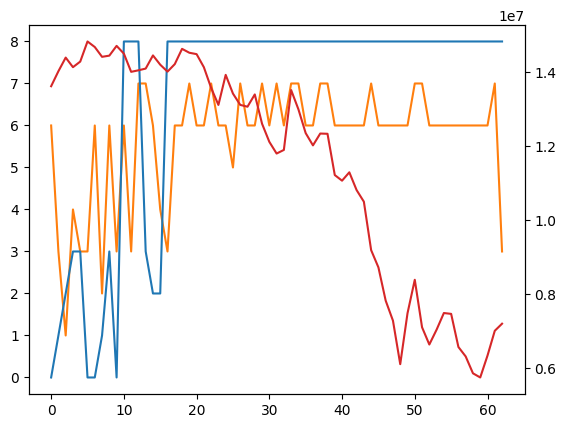

In [ ]:
y_0 = betti_num_arr_0
y_1 = betti_num_arr_1
y = time_series_arr
x = time_arr

fig, ax1 = plt.subplots()

ax1.plot(x, y_0, color='tab:orange')
ax1.plot(x, y_1, color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(x, y, color='tab:red')

plt.show()

In [ ]:
time_series = pd.read_csv("SP5001.csv", header=None).to_numpy().squeeze()
time_series = np.log(np.array([i[1] for i in time_series]))

point_clouds = TakenPointCloud(time_series, n, d, w)

betti_num_arr_0 = []
betti_num_arr_1 = []
time_series_arr = []
time_arr = []

for i in range(len(point_clouds)):
    betti_num_arr_0.append(classical_betti_solver(point_clouds[i], epsilon, 0))
    betti_num_arr_1.append(classical_betti_solver(point_clouds[i], epsilon, 1))
    time_series_arr.append(10 ** time_series[i])
    time_arr.append(i)

C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: divide by zero encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian
C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: invalid value encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian
C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: divide by zero encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian
C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: invalid value encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian
C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_26940\898678006.py:31: RuntimeWarning: divide by zero encountered in divide
  return temp * 6 / max_eigenval # return val should be Hermitian
C:\Users\ywang_sy2849a\AppData\L

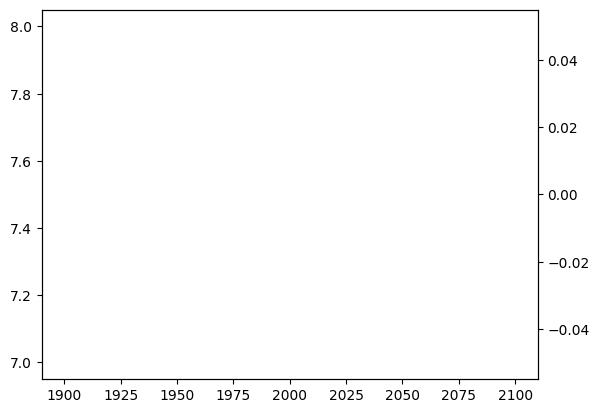

In [617]:
y_0 = betti_num_arr_0
y_1 = betti_num_arr_1
y = time_series_arr
x = time_arr

fig, ax1 = plt.subplots()

ax1.plot(x,y_0)
ax1.plot(x,y_1)

ax2 = ax1.twinx()
ax2.plot(x, y)

plt.show()

In [ ]:
df = pd.read_csv("KPAtlasDB_2022_en.csv", encoding='latin-1')
df = df[df['Indicator'] == "Transgender people: Population size estimate"]
years = df['Time Period'].values
counts = df['Data value'].values

time_series = []

for i in range(min(years), max(years) + 1):
    mask = [x == i for x in years]

    sum = 0
    for j in range(len(years)):
        sum += float(counts[j]) * mask[j]

    time_series.append(sum)

time_series = np.array(time_series)

point_clouds = TakenPointCloud(time_series, n, d, w)

betti_num_arr_0 = []
betti_num_arr_1 = []
time_series_arr = []
time_arr = []

for i in range(len(point_clouds)):
    betti_num_arr_0.append(classical_betti_solver(point_clouds[i], epsilon, 0))
    betti_num_arr_1.append(classical_betti_solver(point_clouds[i], epsilon, 1))
    time_series_arr.append(10 ** time_series[i])
    time_arr.append(i)


In [ ]:
y_0 = betti_num_arr_0
y_1 = betti_num_arr_1
y = time_series_arr
x = time_arr

fig, ax1 = plt.subplots()

ax1.plot(x,y_0)
ax1.plot(x,y_1)

ax2 = ax1.twinx()
ax2.plot(x, y)

plt.show()